In [1]:
### Script by Alexander Lojko used in Lojko et al., 2026 for detection of Rossby wave tilt and amplitude. 

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests

### Need for algorithm:
from skimage.measure import find_contours
from scipy.stats import linregress


## Load in data:

In [28]:
# Option 1 (Feel free to uncomment out xarray open command section):

# Manually download PV data (the one used in Lojko et al., 2026 is available at: https://github.com/AlexLojko/RWB_tilt). It involves 5 netcdf files:
# pv_ecmwf_test (50 ensemble ecmwf), pv_gfs_test (20 ensemble gefs), pv_mpas3_75_test (5 ensemble mpas-3.75 km with refinement mesh), pv_mpas15_test
# (5 ensemble mpas-15 km), pv_mpas_60_test (5 ensemble mpas-60 km). 

#PV_mpas60 = xr.open_dataset('pv_mpas_60_test.nc')['ertel_pv']
#PV_mpas15 = xr.open_dataset('pv_mpas15_test.nc')['ertel_pv']
#PV_mpas3 = xr.open_dataset('pv_mpas3_75_test.nc')['ertel_pv']
#PV_ecmwf = xr.open_dataset('pv_ecmwf_test.nc')['__xarray_dataarray_variable__']
#PV_gfs = xr.open_dataset('pv_gefs_test.nc')['__xarray_dataarray_variable__']

In [22]:
# Option 2: Auto-download PV data used in manuscript onto script (download is from Github with file size total of about 6 mb).

### NOTE THAT THIS WILL START A DATA DOWNLOAD ###

def download_and_open(url, filename):
    r = requests.get(url)
    with open(filename, "wb") as f:
        f.write(r.content)
    return xr.open_dataset(filename)

url_ecmwf = "https://raw.githubusercontent.com/AlexLojko/RWB_tilt/main/pv_ecmwf_test.nc"
filename_ecmwf = "pv_ecmwf_test.nc"

url_gfs = "https://raw.githubusercontent.com/AlexLojko/RWB_tilt/main/pv_gefs_test.nc"
filename_gfs = "pv_gefs_test.nc"

url_mpas3 = "https://raw.githubusercontent.com/AlexLojko/RWB_tilt/main/pv_mpas3_75_test.nc"
filename_mpas3 = "pv_mpas3_75_test.nc"

url_mpas15 = "https://raw.githubusercontent.com/AlexLojko/RWB_tilt/main/pv_mpas15_test.nc"
filename_mpas15 = "pv_mpas15_test.nc"

url_mpas60 = "https://raw.githubusercontent.com/AlexLojko/RWB_tilt/main/pv_mpas_60_test.nc"
filename_mpas60 = "pv_mpas_60_test.nc"

PV_ecmwf  = download_and_open(url_ecmwf, filename_ecmwf)['__xarray_dataarray_variable__']  # variable is PV.
PV_gfs    = download_and_open(url_gfs, filename_gfs)['__xarray_dataarray_variable__']
PV_mpas3  = download_and_open(url_mpas3, filename_mpas3)['ertel_pv']
PV_mpas15 = download_and_open(url_mpas15, filename_mpas15)['ertel_pv']
PV_mpas60 = download_and_open(url_mpas60, filename_mpas60)['ertel_pv']

In [29]:
### Quick fix (for now) to get all PV datasets into the same format. 

PV_mpas3 = xr.zeros_like(PV_ecmwf[0:5,:,:]) + PV_mpas3.values
PV_mpas15 = xr.zeros_like(PV_ecmwf[0:5,:,:]) + PV_mpas15.values
PV_mpas60 = xr.zeros_like(PV_ecmwf[0:5,:,:]) + PV_mpas60.values

In [31]:
# Concat all PV day 6 data together: ecmwf, ncep, mpas_60, mpas_15, mpas_3

PV_all = xr.concat([PV_ecmwf, PV_gfs, PV_mpas60, PV_mpas15, PV_mpas3], dim='ensemble0')
PV_global = PV_all
pv_data = PV_global.sel(lat_0=slice(75, 40), lon_0=slice(-80, -5))  # Rossby wave region of interest over North Atlantic

## Rossby wave tilt algorithm:

In [36]:
### A very minor issue with the current data is that ensemble member 20 does not correctly detect the Rossby wave feature due to the Rossby wave
### feature being of very small size. That being said, this ensemble member is still classified as expected by the algorithm. A future fix
### could involve filtering out closed contours within the domain. 

In [37]:
### Defining parameters: 

PVU_THRESHOLD = 2 # Define threshold for unclassified slope and minimum contour length
THRESHOLD = 0.15  # Slope threshold for unclassified classification (Original = 0.15)
MIN_CONTOUR_LENGTH = 30  # Minimum number of points in contour to classify / skip too small contours (Original = 30)
AMPLIFICATION_LAT = 62  # Threshold latitude for more or less amplified (Original = 62)

# Dictionary to store ensemble indices for each Rossby wave group:
classification_indices = {
    "More Amplified Cyclonic": [],
    "Less Amplified Cyclonic": [],
    "More Amplified Neutral": [],
    "Less Amplified Neutral": [],
    "More Amplified Anticyclonic": [],
    "Less Amplified Anticyclonic": [],
}
amplitude = []

def analyze_rwb(pv_field, lat, lon, threshold=THRESHOLD, min_length=MIN_CONTOUR_LENGTH):
    """
    Identifies RWB regions and classifies tilt using an exponential weighted linear regression. High lat. gets more weight!
    """
    contours = find_contours(pv_field, PVU_THRESHOLD)

    if not contours:
        return None

    # 1. Get longest contour
    longest_contour = max(contours, key=len)
    lon_values = lon[(longest_contour[:, 1]).astype(int)]
    lat_values = lat[(longest_contour[:, 0]).astype(int)]

    # 2. Get topmost coordinate
    top_index = np.argmax(lat_values)
    bottom_index = np.argmin(lat_values)
    top_lat = lat_values[top_index]
    bottom_lat = lat_values[bottom_index]
    amplitude.append(top_lat)
    lower_bound_lat = top_lat - bottom_lat # bottom lat in the Lojko et al., 2026 refers to 40N latitude cut-off .

    # 3. Filter to minimum latitude of dataset (in Lojko et al., 2026, refers to 40° band)
    valid_idx = np.where(lat_values >= lower_bound_lat)[0]
    lon_values = lon_values[valid_idx]
    lat_values = lat_values[valid_idx]

    if len(lon_values) < min_length or np.all(lon_values == lon_values[0]):
        return None

##### WEIGHTED LINEAR REGRESSION SECTION #####
    # Weights increase with latitude to improve identification of tilt direction in long contours. 
    weights = np.exp((lat_values - np.min(lat_values)) / 35)   # The value 35 can be experimented with, it is a component of weighting. 

    # Fit lat = slope * lon + intercept with weights
    fit = np.polyfit(lon_values, lat_values, deg=1, w=weights)
    slope, intercept = fit

    # Classification
    if slope < -threshold:
        base_tilt = "Cyclonic"
    elif slope > threshold:
        base_tilt = "Anticyclonic"
    else:
        base_tilt = "Neutral"

    tilt = f"{'More Amplified' if top_lat > AMPLIFICATION_LAT else 'Less Amplified'} {base_tilt}"

    return {
        "contour": (lon_values, lat_values),
        "tilt": tilt,
        "slope": slope,
        "intercept": intercept
    }

## Plotting: (Plot 1: All ensemble members with classification, Plot 2: Ensemble mean of groups plotted)

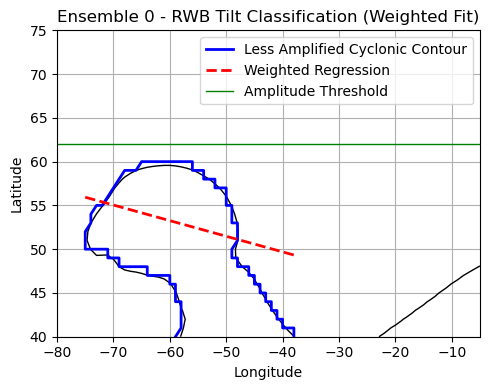

Ensemble 0, Tilt: Less Amplified Cyclonic


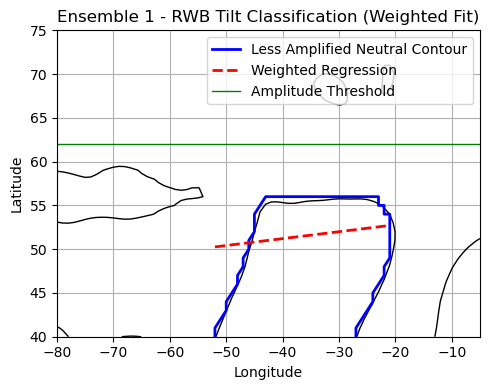

Ensemble 1, Tilt: Less Amplified Neutral


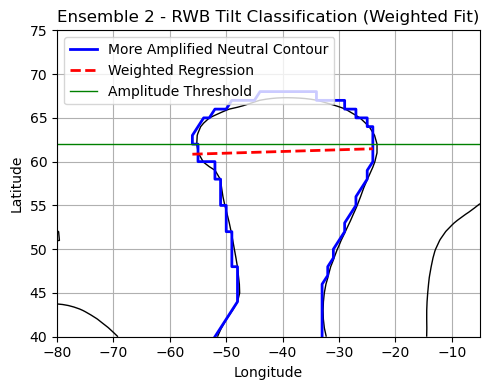

Ensemble 2, Tilt: More Amplified Neutral


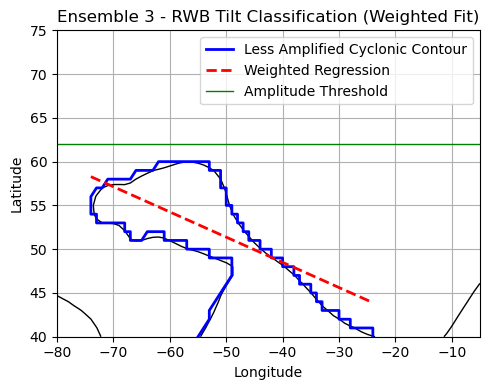

Ensemble 3, Tilt: Less Amplified Cyclonic


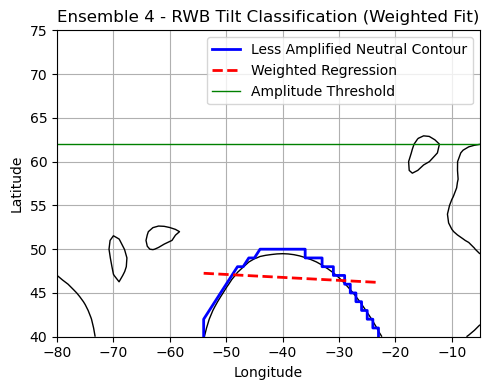

Ensemble 4, Tilt: Less Amplified Neutral


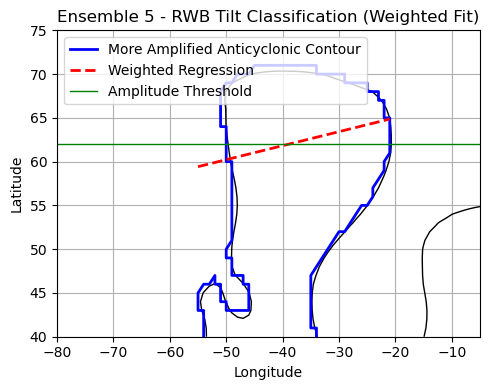

Ensemble 5, Tilt: More Amplified Anticyclonic


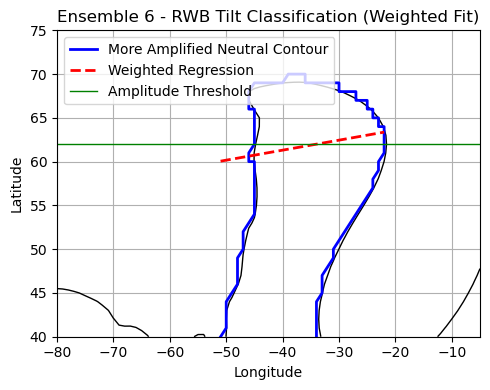

Ensemble 6, Tilt: More Amplified Neutral


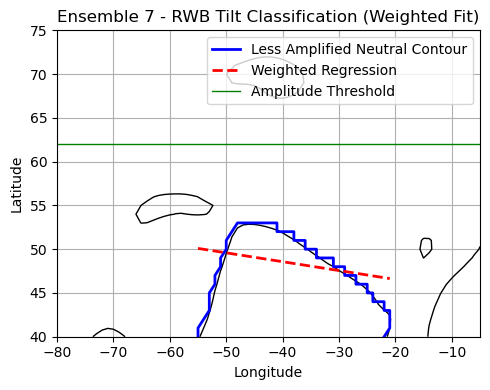

Ensemble 7, Tilt: Less Amplified Neutral


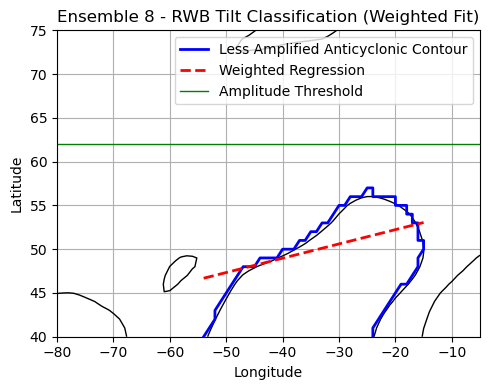

Ensemble 8, Tilt: Less Amplified Anticyclonic


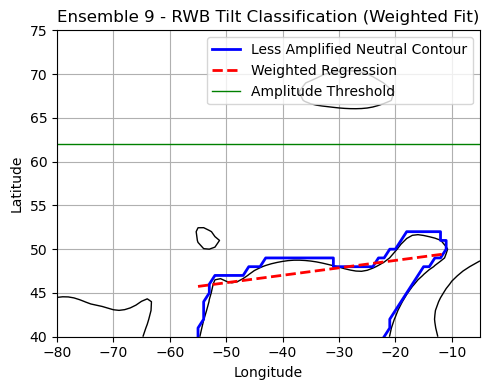

Ensemble 9, Tilt: Less Amplified Neutral


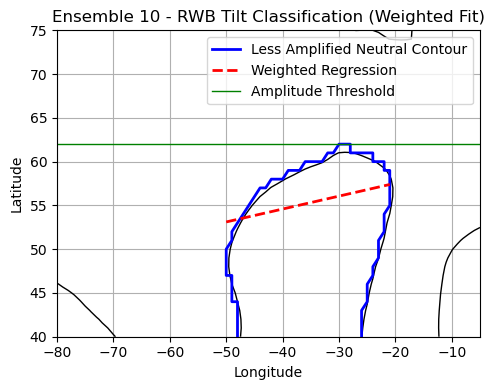

Ensemble 10, Tilt: Less Amplified Neutral


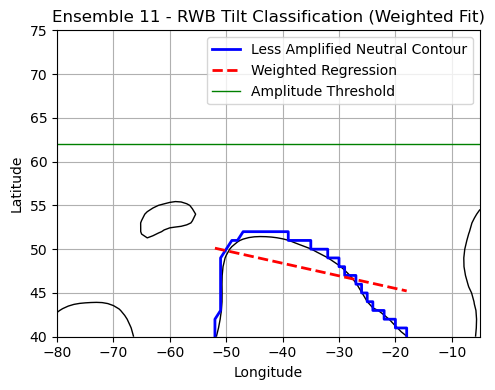

Ensemble 11, Tilt: Less Amplified Neutral


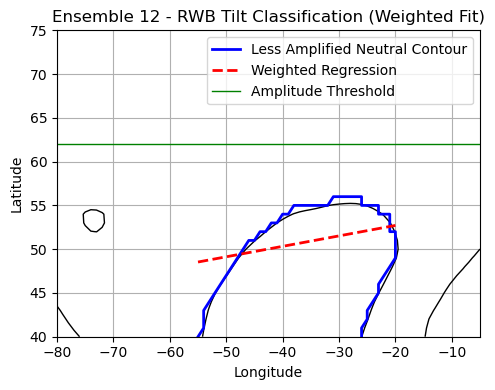

Ensemble 12, Tilt: Less Amplified Neutral


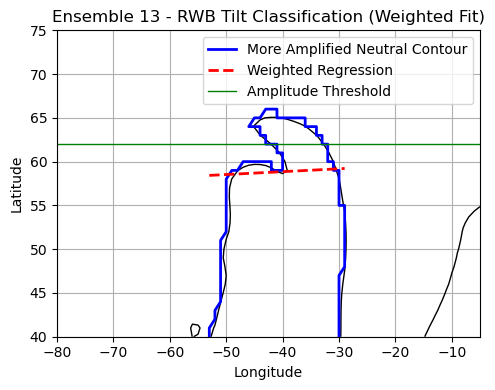

Ensemble 13, Tilt: More Amplified Neutral


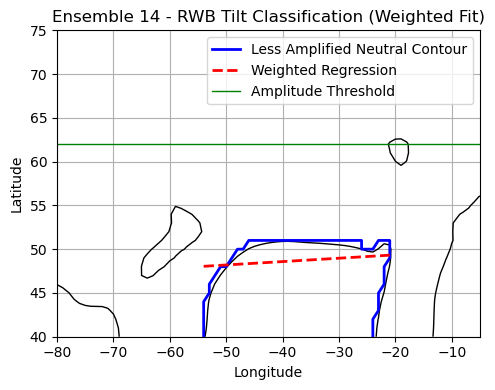

Ensemble 14, Tilt: Less Amplified Neutral


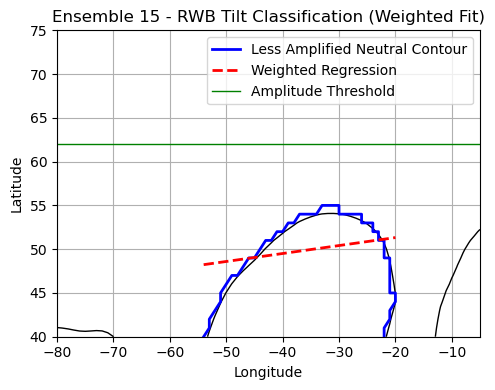

Ensemble 15, Tilt: Less Amplified Neutral


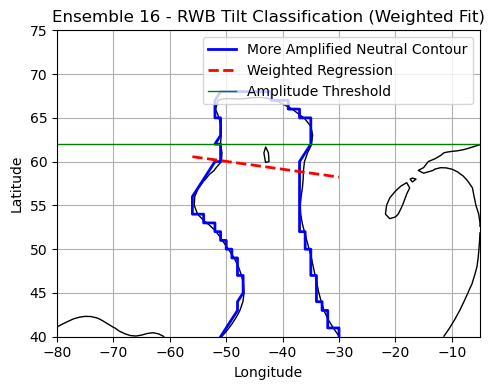

Ensemble 16, Tilt: More Amplified Neutral


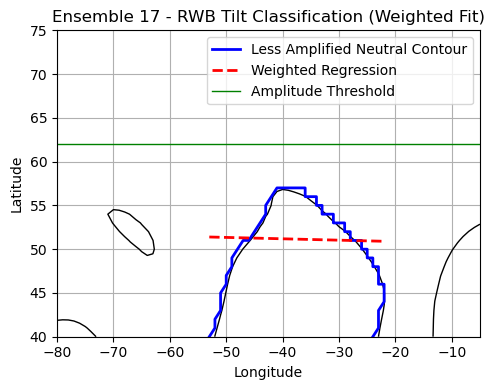

Ensemble 17, Tilt: Less Amplified Neutral


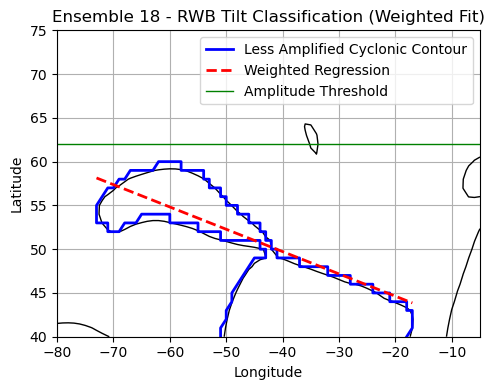

Ensemble 18, Tilt: Less Amplified Cyclonic


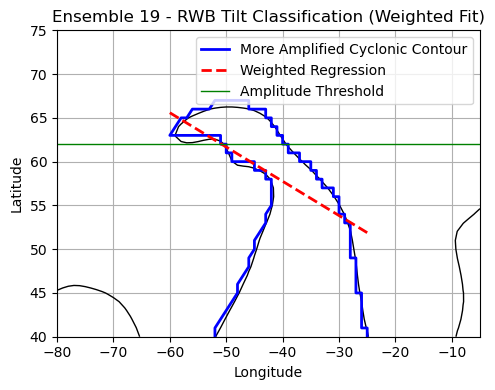

Ensemble 19, Tilt: More Amplified Cyclonic


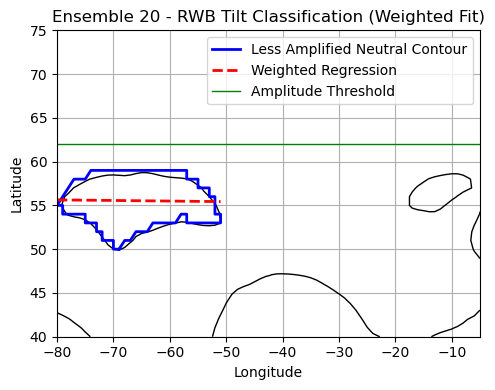

Ensemble 20, Tilt: Less Amplified Neutral


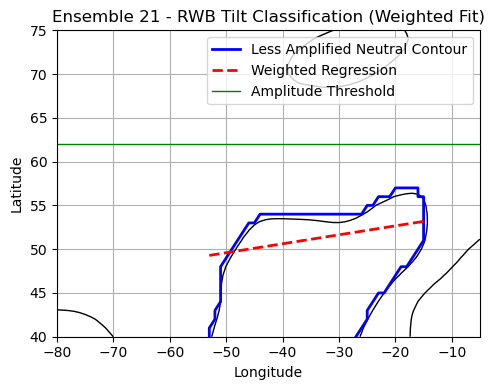

Ensemble 21, Tilt: Less Amplified Neutral


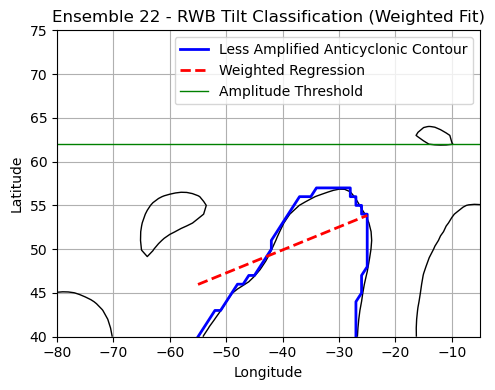

Ensemble 22, Tilt: Less Amplified Anticyclonic


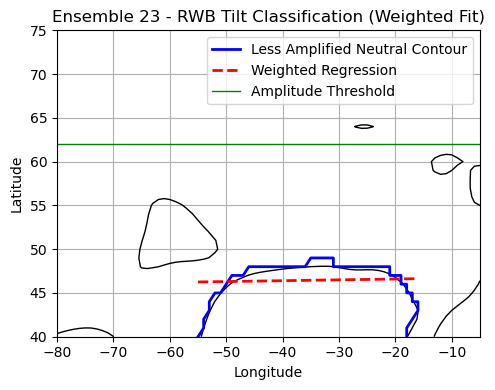

Ensemble 23, Tilt: Less Amplified Neutral


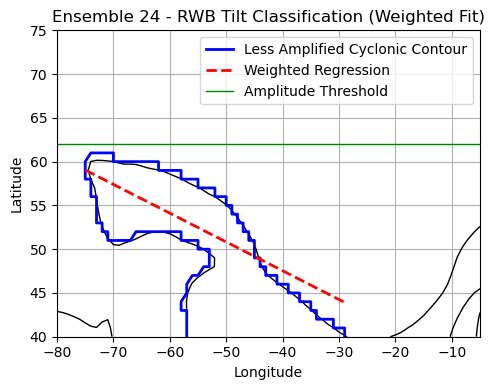

Ensemble 24, Tilt: Less Amplified Cyclonic


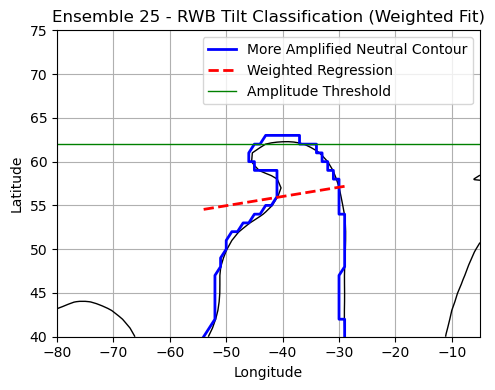

Ensemble 25, Tilt: More Amplified Neutral


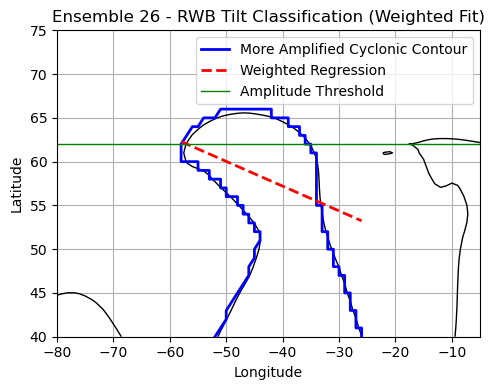

Ensemble 26, Tilt: More Amplified Cyclonic


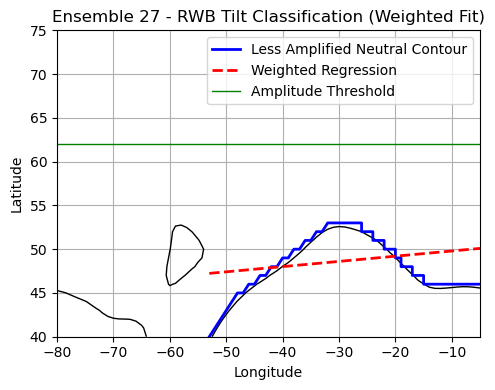

Ensemble 27, Tilt: Less Amplified Neutral


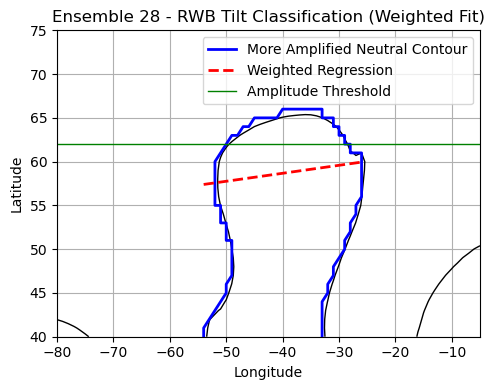

Ensemble 28, Tilt: More Amplified Neutral


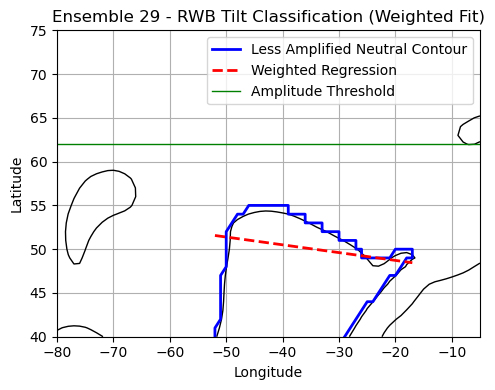

Ensemble 29, Tilt: Less Amplified Neutral


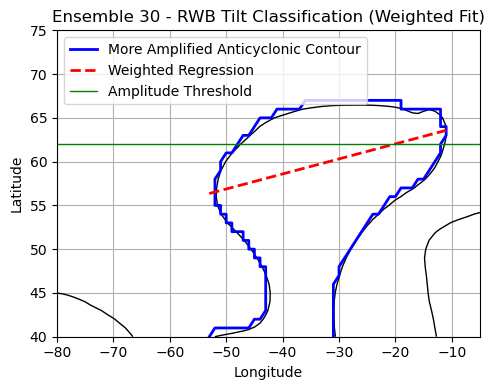

Ensemble 30, Tilt: More Amplified Anticyclonic


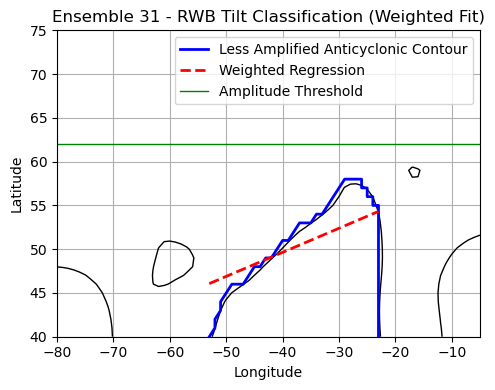

Ensemble 31, Tilt: Less Amplified Anticyclonic


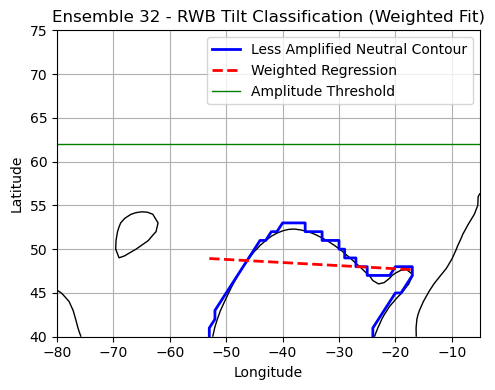

Ensemble 32, Tilt: Less Amplified Neutral


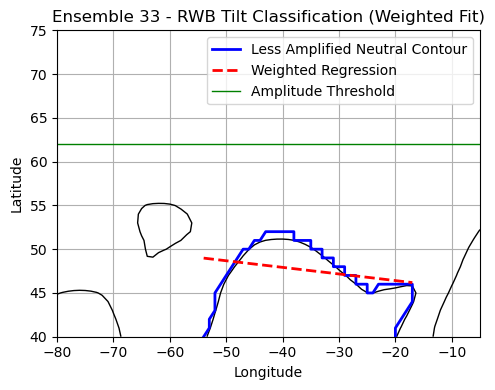

Ensemble 33, Tilt: Less Amplified Neutral


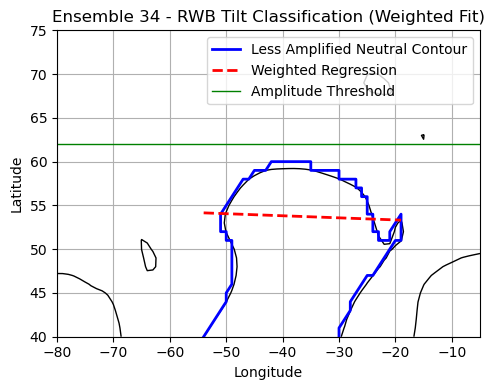

Ensemble 34, Tilt: Less Amplified Neutral


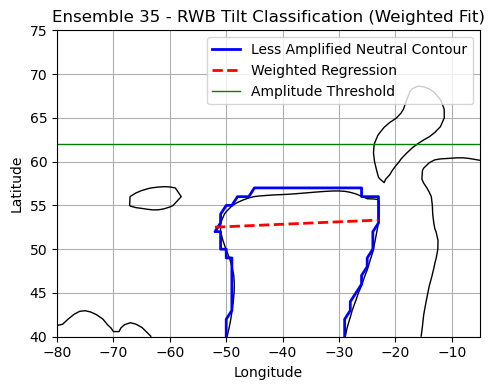

Ensemble 35, Tilt: Less Amplified Neutral


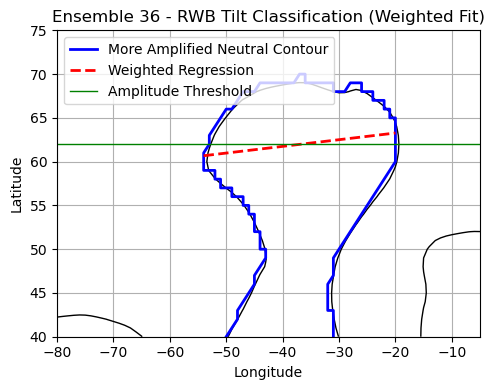

Ensemble 36, Tilt: More Amplified Neutral


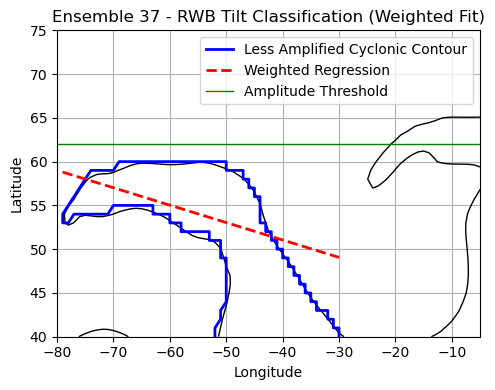

Ensemble 37, Tilt: Less Amplified Cyclonic


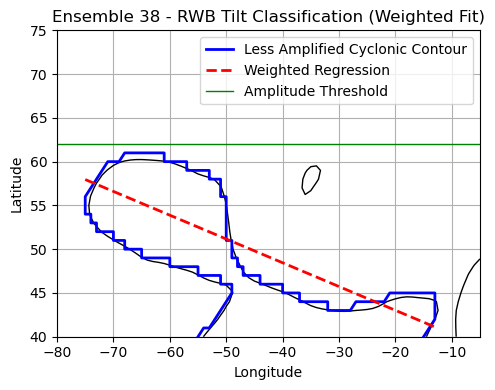

Ensemble 38, Tilt: Less Amplified Cyclonic


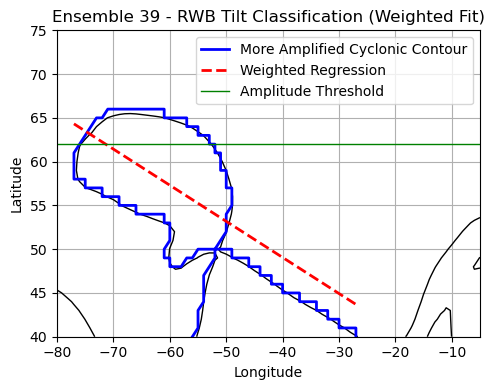

Ensemble 39, Tilt: More Amplified Cyclonic


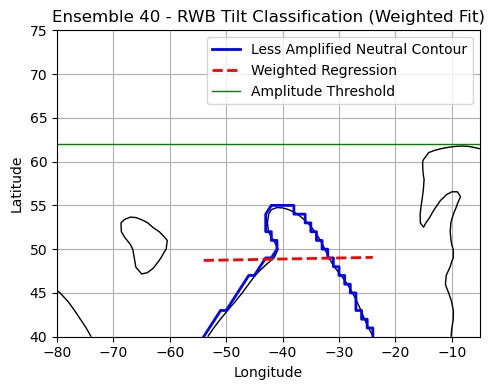

Ensemble 40, Tilt: Less Amplified Neutral


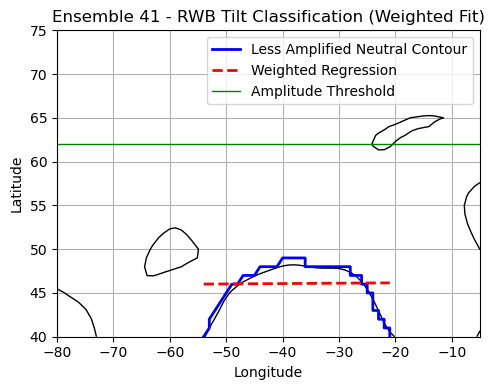

Ensemble 41, Tilt: Less Amplified Neutral


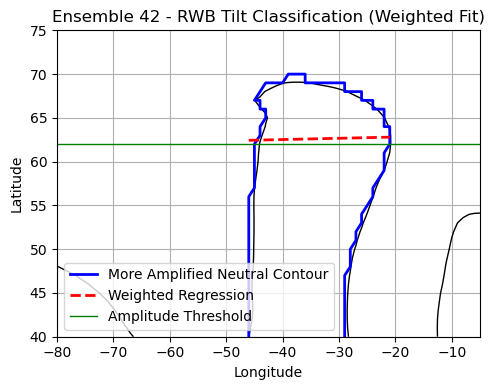

Ensemble 42, Tilt: More Amplified Neutral


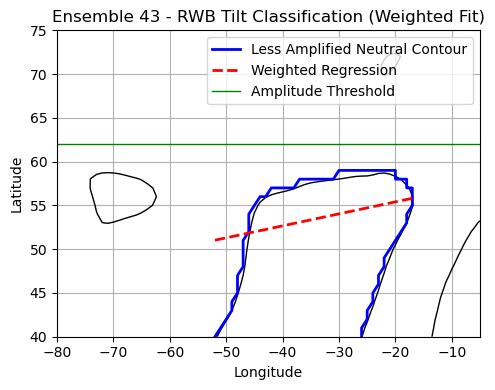

Ensemble 43, Tilt: Less Amplified Neutral


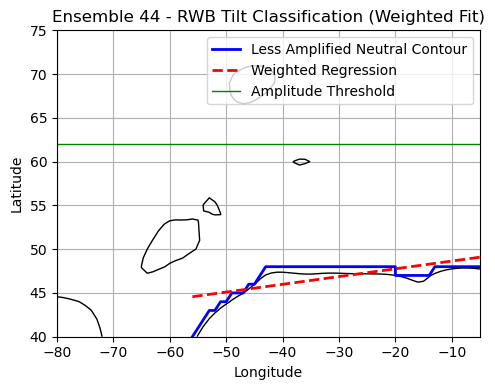

Ensemble 44, Tilt: Less Amplified Neutral


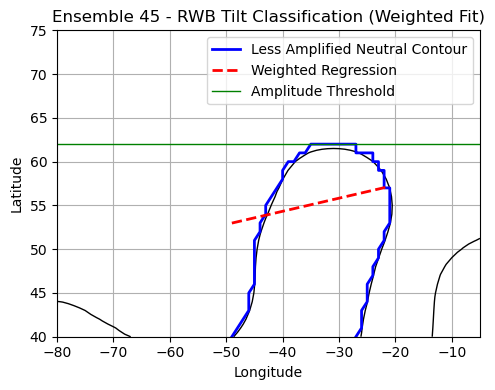

Ensemble 45, Tilt: Less Amplified Neutral


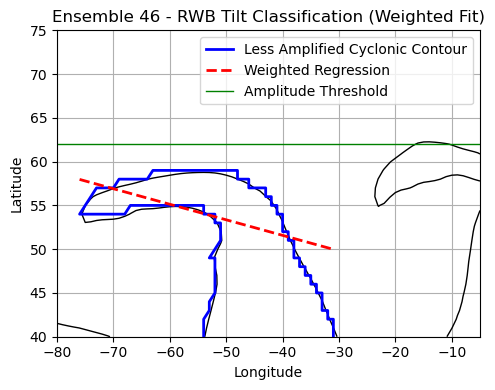

Ensemble 46, Tilt: Less Amplified Cyclonic


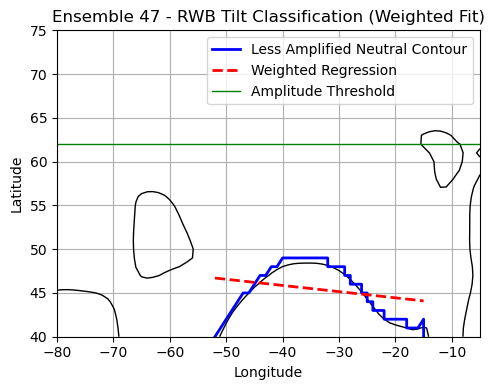

Ensemble 47, Tilt: Less Amplified Neutral


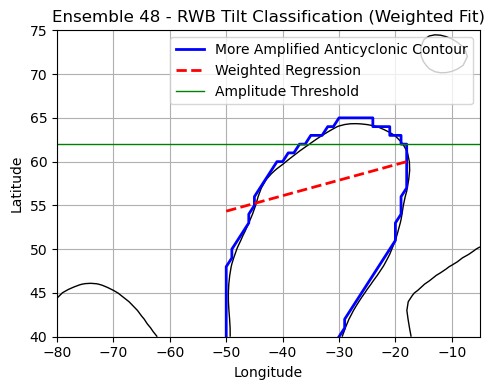

Ensemble 48, Tilt: More Amplified Anticyclonic


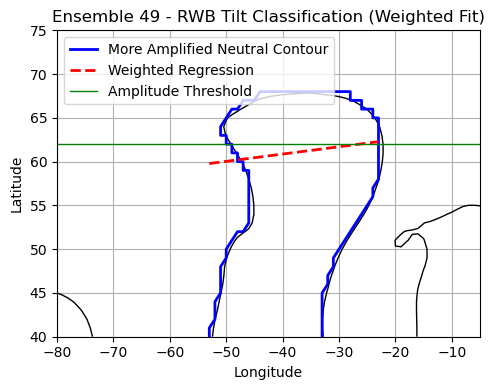

Ensemble 49, Tilt: More Amplified Neutral


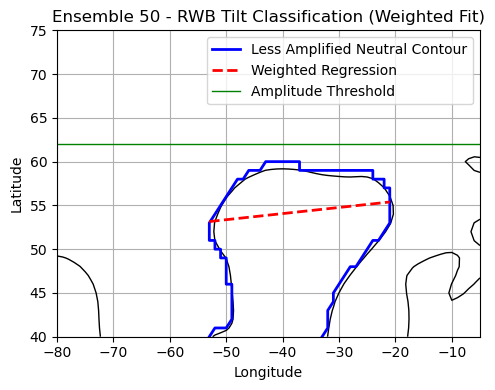

Ensemble 50, Tilt: Less Amplified Neutral


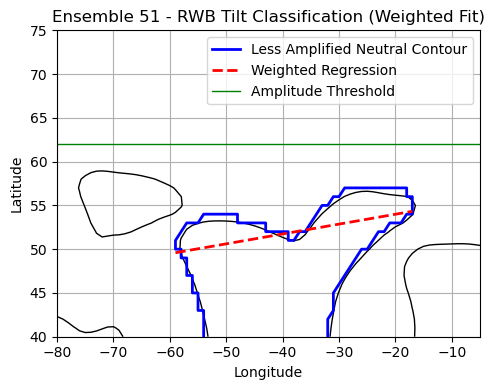

Ensemble 51, Tilt: Less Amplified Neutral


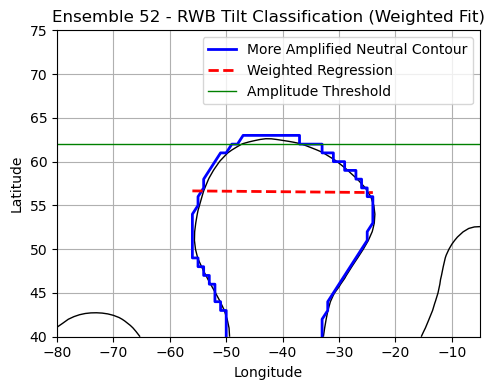

Ensemble 52, Tilt: More Amplified Neutral


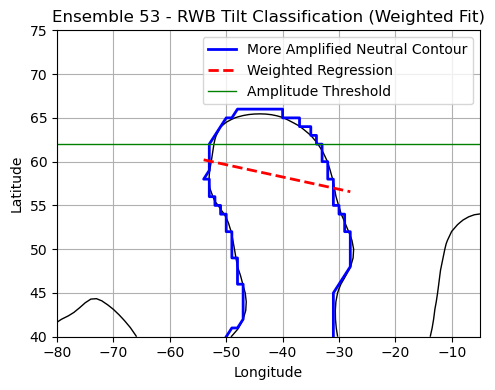

Ensemble 53, Tilt: More Amplified Neutral


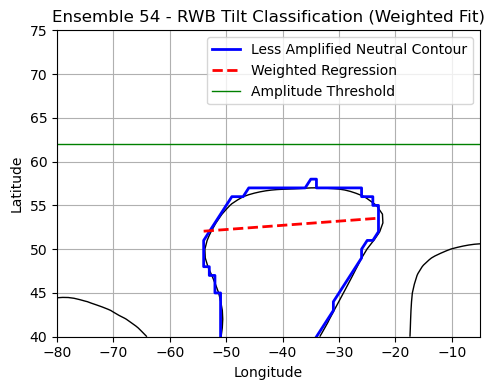

Ensemble 54, Tilt: Less Amplified Neutral


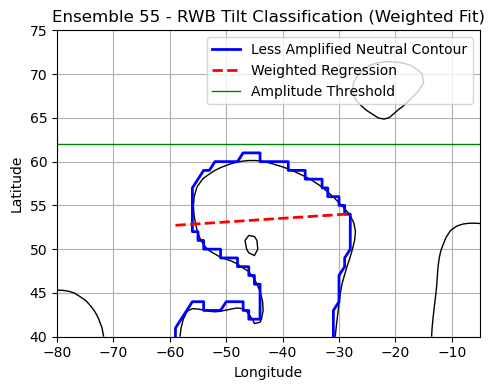

Ensemble 55, Tilt: Less Amplified Neutral


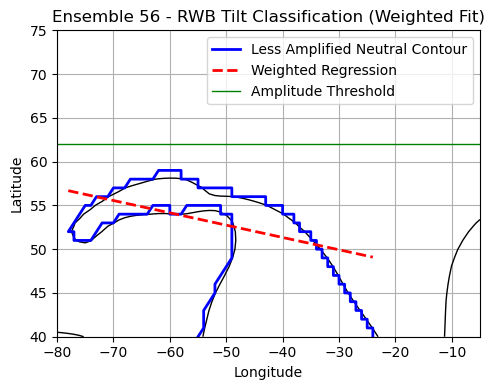

Ensemble 56, Tilt: Less Amplified Neutral


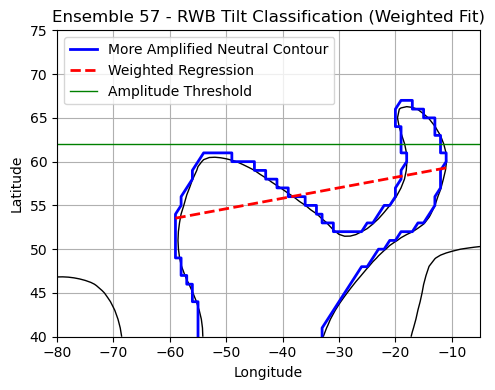

Ensemble 57, Tilt: More Amplified Neutral


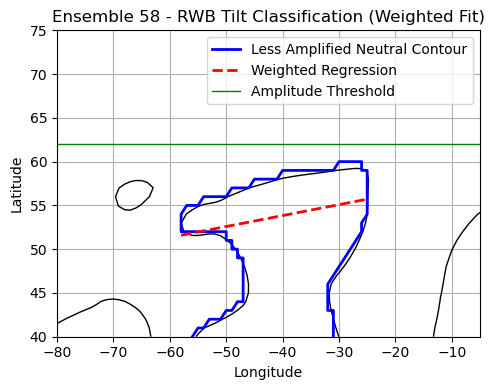

Ensemble 58, Tilt: Less Amplified Neutral


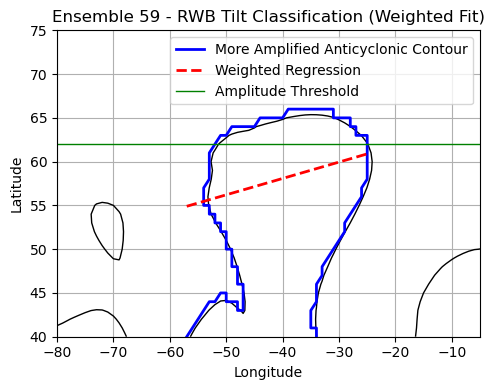

Ensemble 59, Tilt: More Amplified Anticyclonic


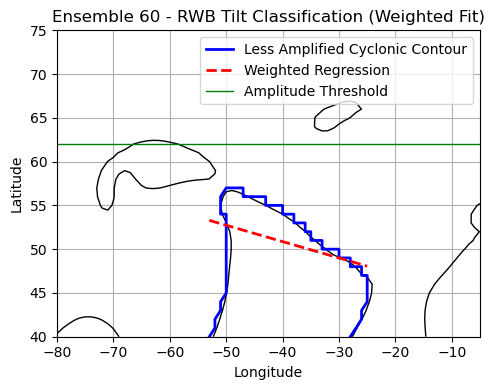

Ensemble 60, Tilt: Less Amplified Cyclonic


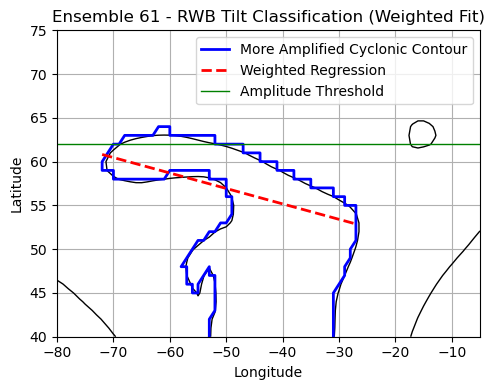

Ensemble 61, Tilt: More Amplified Cyclonic


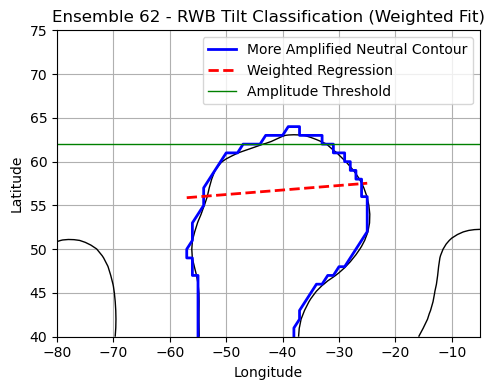

Ensemble 62, Tilt: More Amplified Neutral


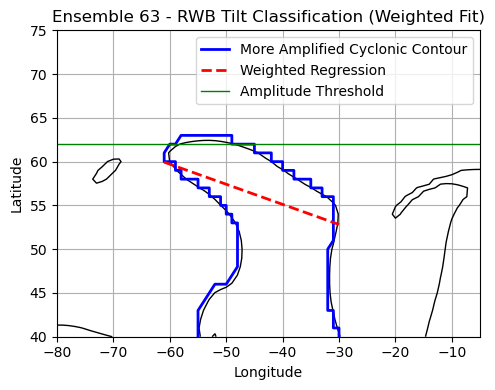

Ensemble 63, Tilt: More Amplified Cyclonic


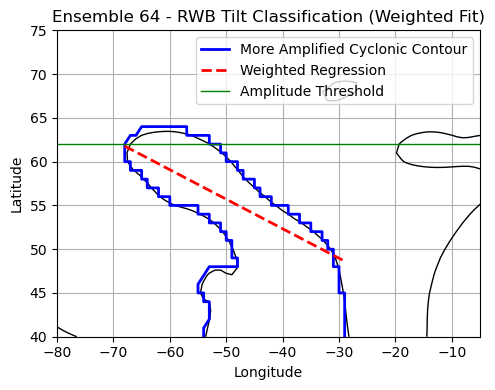

Ensemble 64, Tilt: More Amplified Cyclonic


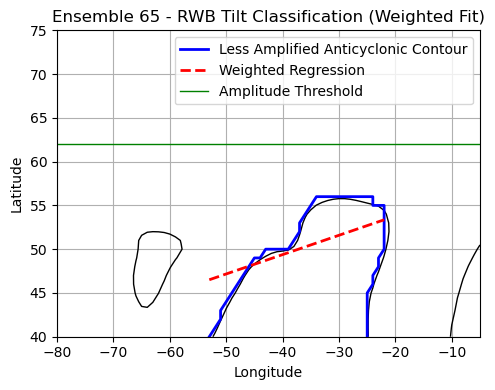

Ensemble 65, Tilt: Less Amplified Anticyclonic


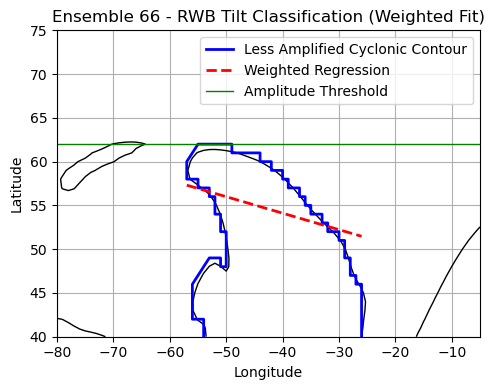

Ensemble 66, Tilt: Less Amplified Cyclonic


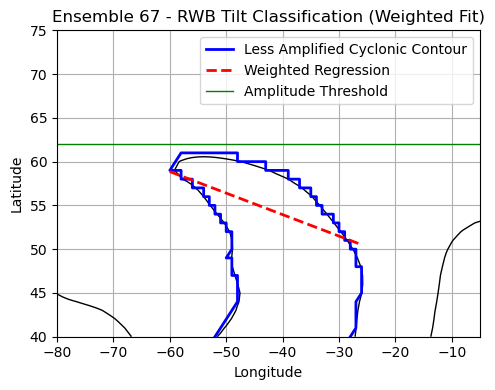

Ensemble 67, Tilt: Less Amplified Cyclonic


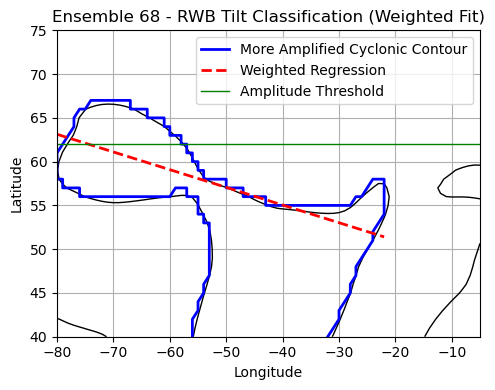

Ensemble 68, Tilt: More Amplified Cyclonic


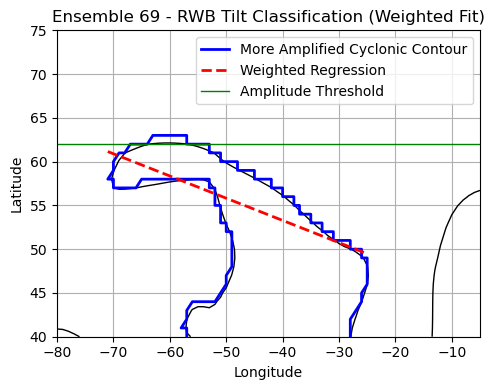

Ensemble 69, Tilt: More Amplified Cyclonic


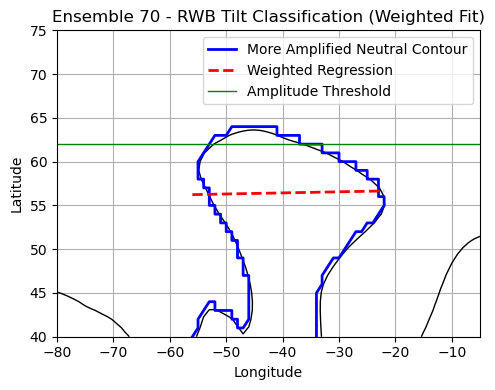

Ensemble 70, Tilt: More Amplified Neutral


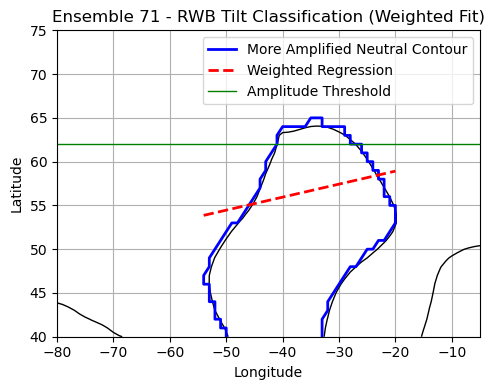

Ensemble 71, Tilt: More Amplified Neutral


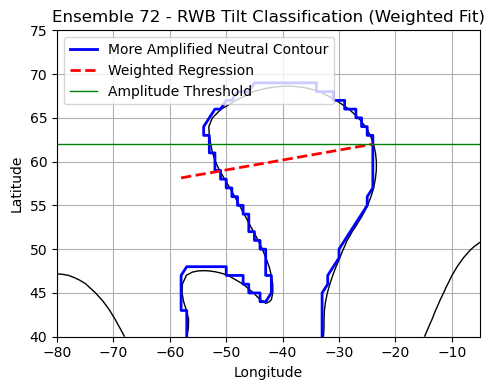

Ensemble 72, Tilt: More Amplified Neutral


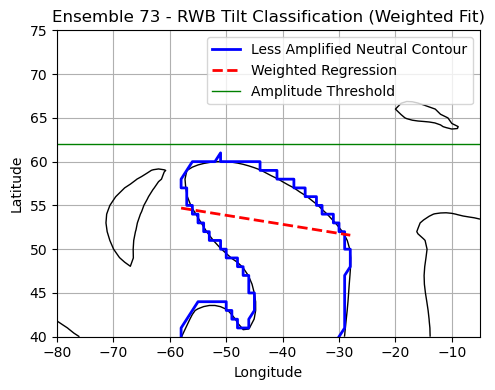

Ensemble 73, Tilt: Less Amplified Neutral


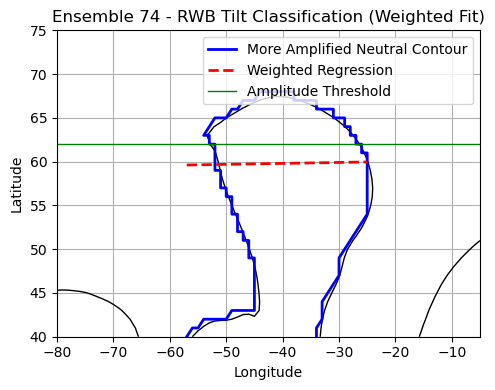

Ensemble 74, Tilt: More Amplified Neutral


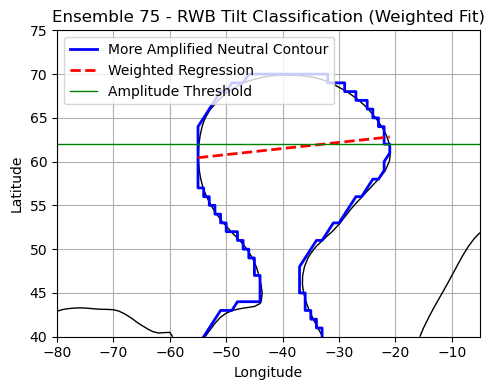

Ensemble 75, Tilt: More Amplified Neutral


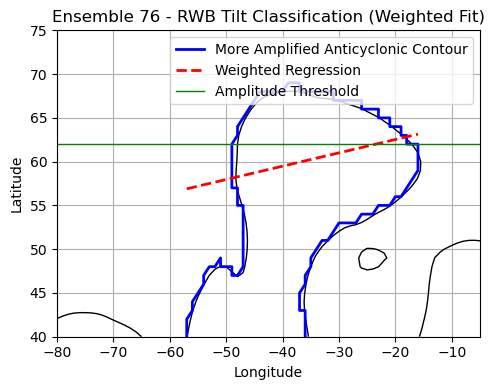

Ensemble 76, Tilt: More Amplified Anticyclonic


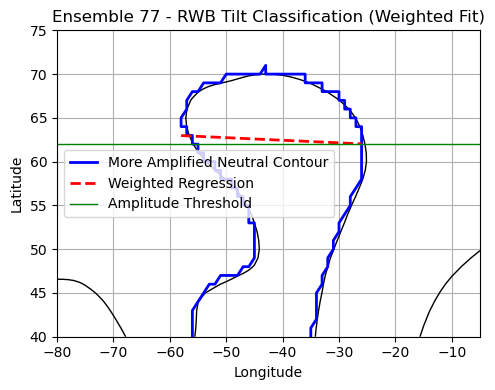

Ensemble 77, Tilt: More Amplified Neutral


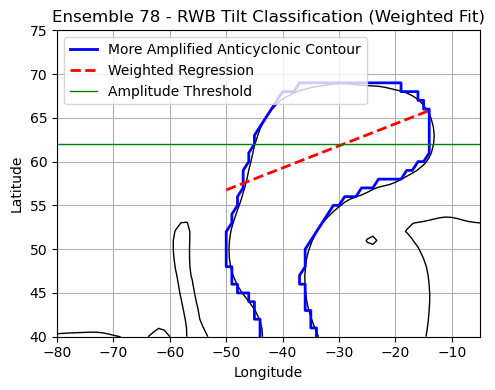

Ensemble 78, Tilt: More Amplified Anticyclonic


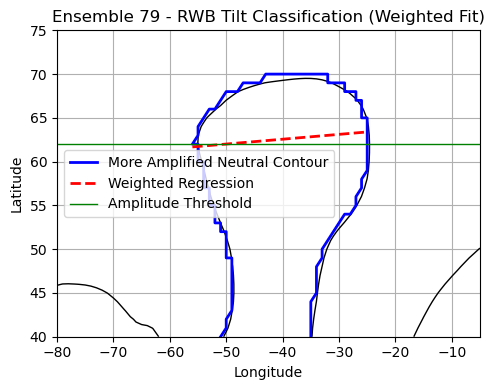

Ensemble 79, Tilt: More Amplified Neutral


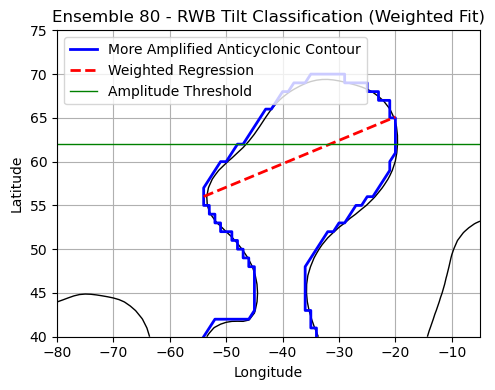

Ensemble 80, Tilt: More Amplified Anticyclonic


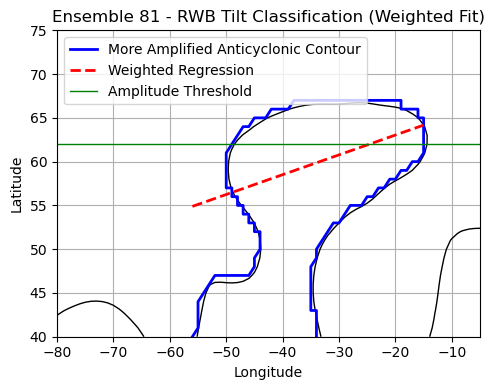

Ensemble 81, Tilt: More Amplified Anticyclonic


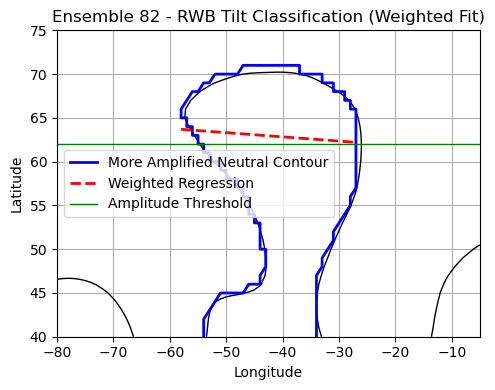

Ensemble 82, Tilt: More Amplified Neutral


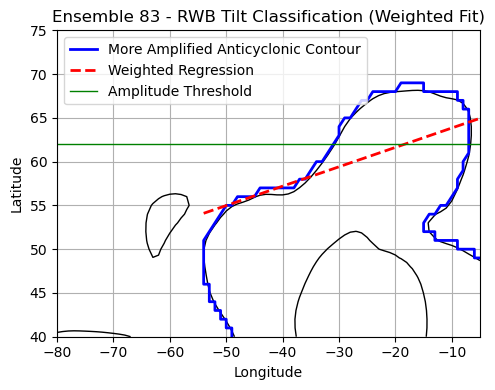

Ensemble 83, Tilt: More Amplified Anticyclonic


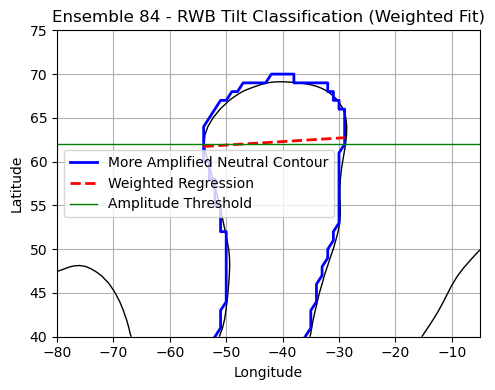

Ensemble 84, Tilt: More Amplified Neutral


In [38]:
# Loop through ensemble members
for ens in range(pv_data.shape[0]):
    rwb_result = analyze_rwb(pv_data[ens].values, ds.lat_0.values, ds.lon_0.values)

    if rwb_result:
        lon_values, lat_values = rwb_result["contour"]
        tilt = rwb_result["tilt"]
        slope = rwb_result["slope"]
        intercept = rwb_result["intercept"]

        classification_indices[tilt].append(ens)

        # Fitted regression line
        lon_fit = np.linspace(lon_values.min(), lon_values.max(), 100)  # 100 is arbitary, just to get general outline of fitted line. 
        lat_fit = slope * lon_fit + intercept

        # Plot
        plt.figure(figsize=(5, 4))
        plt.contour(ds.lon_0, ds.lat_0, pv_data[ens], levels=[PVU_THRESHOLD], colors='k', linewidths=1)
        plt.plot(lon_values, lat_values, label=f"{tilt} Contour", linewidth=2, color='blue')
        plt.plot(lon_fit, lat_fit, '--', label='Weighted Regression', color='red', linewidth=2)
        plt.axhline(y=62, color='green', linewidth=1, label="Amplitude Threshold")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(f"Ensemble {ens} - RWB Tilt Classification (Weighted Fit)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"Ensemble {ens}, Tilt: {tilt}")
        
# Convert list of indices to NumPy arrays
classification_arrays = {
    key: np.array(val) for key, val in classification_indices.items()
}

In [39]:
### Classification of each ensemble into one of the six groups:

classification_arrays

{'More Amplified Cyclonic': array([19, 26, 39, 61, 63, 64, 68, 69]),
 'Less Amplified Cyclonic': array([ 0,  3, 18, 24, 37, 38, 46, 60, 66, 67]),
 'More Amplified Neutral': array([ 2,  6, 13, 16, 25, 28, 36, 42, 49, 52, 53, 57, 62, 70, 71, 72, 74,
        75, 77, 79, 82, 84]),
 'Less Amplified Neutral': array([ 1,  4,  7,  9, 10, 11, 12, 14, 15, 17, 20, 21, 23, 27, 29, 32, 33,
        34, 35, 40, 41, 43, 44, 45, 47, 50, 51, 54, 55, 56, 58, 73]),
 'More Amplified Anticyclonic': array([ 5, 30, 48, 59, 76, 78, 80, 81, 83]),
 'Less Amplified Anticyclonic': array([ 8, 22, 31, 65])}

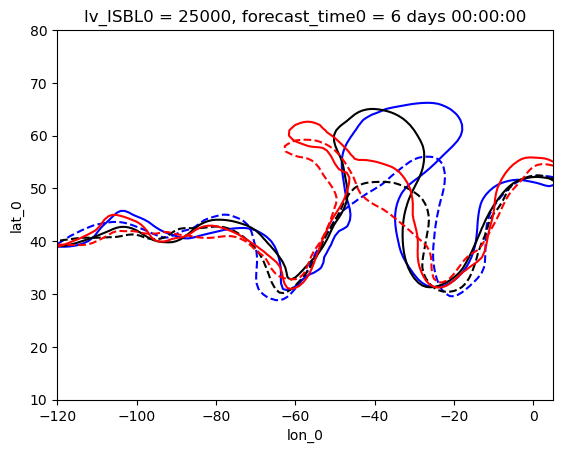

In [40]:
### Validation test for tilt direction and amplitude:

PV_global[list(classification_arrays.values())[4],:,:].mean(axis=0).plot.contour(levels=[2],colors='b')
PV_global[list(classification_arrays.values())[5],:,:].mean(axis=0).plot.contour(levels=[2],colors='b',linestyles='--')

PV_global[list(classification_arrays.values())[2],:,:].mean(axis=0).plot.contour(levels=[2],colors='k')
PV_global[list(classification_arrays.values())[3],:,:].mean(axis=0).plot.contour(levels=[2],colors='k',linestyles='--')

PV_global[list(classification_arrays.values())[0],:,:].mean(axis=0).plot.contour(levels=[2],colors='r')
PV_global[list(classification_arrays.values())[1],:,:].mean(axis=0).plot.contour(levels=[2],colors='r',linestyles='--')